In [3]:
import des_functions
import treecorr
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from more_itertools import locate
plt.style.use('default')
treecorr.__version__

'4.2.0'

In [4]:
# paths to required files
data_dir = '/home/b7009348/projects/WGL_Project/DES-data/'
lens_file = 'DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits'
source_file = 'y1_im3shape_shapes.fits'
source_Zs = 'y1a1-gold-mof-badregion_BPZ.fits'

# Lens-Shear Cross Correlation for Z_l=0.3-0.45

- For shear-shear, using ng.estimate_cov('jackknife') gives "ValueError: Using jackknife covariance requires using patches.", despite
    patches being defined 
- Mask pre-applied

In [9]:
# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+'DES_Y1A1_Lenses_z=0.3-0.45.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=20)

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)

# delte data to free memory
del indexes, data

# define bin and scale params
nbins=20
theta_min=2.5
theta_max=250

nlens = float(len(ra_l)) # number of lenses
nrand = float(len(ra_r)) # number of randoms

# list of source files to compute cross-correlation for 
source_files = ['y1_im3shape_z=0.9-1.3.fits', 'y1_im3shape_z=0.63-0.9.fits', 'y1_im3shape_z=0.43-0.63.fits', 'y1_im3shape_z=0.2-0.43.fits']

# empty arrays to store correlation function data 
Gammat = np.zeros([nbins,len(source_files)])
sig = np.zeros([nbins,len(source_files)])
theta = np.zeros([nbins,len(source_files)])
Boost = np.zeros_like(Gammat)
theta_b = np.zeros_like(Gammat)
boost_err = np.zeros_like(Gammat)

# loops over source files and computes cross-correltaion for different source redshift samples
for i in range(len(source_files)):
    with fits.open(data_dir+source_files[i]) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1'] - data['c1']
        e2 = data['e2'] - data['c2']
        sens = data['m'] + 1.0
        w = data['weight']
    del data
 
    cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, w=w, patch_centers=cat_l.patch_centers)
    cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=cat_l.patch_centers)
    
    # do correlations with lenese, NKCorrelation is used to apply multiplicative correction
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    ng.process(cat_l, cat_s)
    nk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    nk.process(cat_l, cat_k)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    rg.process(cat_r, cat_s)
    rk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rk.process(cat_r, cat_k)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    sens_l = nk.xi
    xi_r = rg.xi
    sens_r = rk.xi
    print(xi_l, xi_r)
    
    # store data in preallocated arrays
    Gammat[:,i] = xi_l/sens_l - xi_r/sens_r
    theta[:,i] = np.exp(ng.meanlogr)
    
    # all errors
    l_err = np.sqrt(ng.varxi) # error on lens-shear cross-corr
    r_err = np.sqrt(rg.varxi) # error on random-shear cross-corr
    sl_err = np.sqrt(nk.varxi) # error on sens for lenses 
    sr_err = np.sqrt(rk.varxi) # error on sens for randoms
    
    # first do errors for division by sens 
    frac_l = l_err/xi_l # fractional error on lens-shear correlation 
    frac_sl = sl_err/sens_l # fractional error on lens sens 
    frac_r = r_err/xi_r # fractional error on random-shear correlation
    frac_sr = sr_err/sens_r # fractional error on random sens
    
    # propagate errors for gamma_t_l and gamma_t_r
    err1 = np.sqrt(frac_l**2 + frac_sl**2) * xi_l/sens_l
    err2 = np.sqrt(frac_r**2 + frac_sr**2) * xi_r/sens_r
    
    # next do errors for subtraction of randoms to get error on gamma_t
    sig[:,i] = np.sqrt(err1**2 + err2**2)

[1.73361275e-03 1.82894124e-03 1.30693430e-03 9.63633308e-04
 8.94612293e-04 6.88892212e-04 6.52227992e-04 6.01262650e-04
 3.86044723e-04 3.78438924e-04 2.38758718e-04 2.44109007e-04
 2.21781145e-04 1.55910007e-04 1.16833088e-04 1.13594224e-04
 1.43664236e-04 1.00468499e-04 7.57217250e-05 4.78854047e-05] [ 9.58139824e-06  2.88159962e-05 -2.94230649e-05 -1.00552518e-05
  6.82311193e-06  4.04482785e-06  2.71502272e-05  1.11485951e-05
  1.11564495e-05  9.07754502e-06  7.46504991e-06 -6.42993305e-06
 -1.23395900e-05 -1.51520215e-05  2.95259022e-06 -1.17859834e-05
  6.08449713e-06  5.51783935e-06 -7.27935697e-06 -1.55616524e-05]
[1.90869747e-03 1.49890114e-03 1.19026865e-03 1.00087175e-03
 8.06930922e-04 6.22975892e-04 4.13615249e-04 3.94484823e-04
 3.35559066e-04 2.85501990e-04 1.99512688e-04 1.62135233e-04
 1.58570492e-04 1.52693671e-04 1.06476255e-04 1.12239435e-04
 1.28655758e-04 7.86543156e-05 6.38936331e-05 3.71451454e-05] [ 1.31561710e-05 -2.11997600e-05 -2.65821882e-05  1.06611059e-

In [6]:
print(Gammat[:,0])

[2.10543376e-03 2.12929087e-03 1.79235103e-03 1.06650975e-03
 9.98746137e-04 9.64518157e-04 6.83175192e-04 7.49428967e-04
 4.35617085e-04 4.22511703e-04 3.22358294e-04 2.71505645e-04
 2.89913923e-04 2.10662120e-04 1.40371163e-04 1.62908128e-04
 1.53060602e-04 1.17123973e-04 9.58682735e-05 8.14791962e-05]


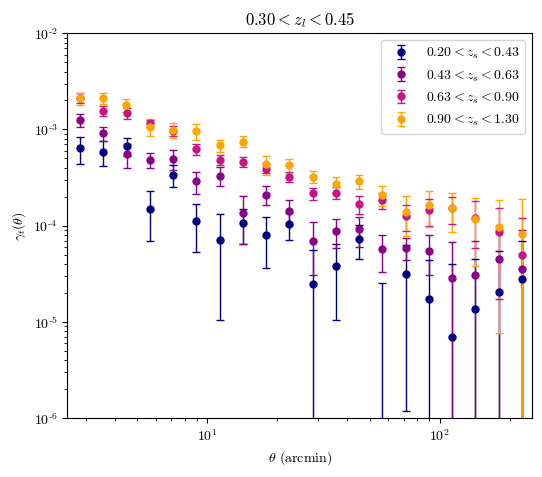

In [8]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'

plt.figure(figsize=[6,5])
plt.errorbar(theta[:,3], Gammat[:,3], yerr=sig[:,3], lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,2], Gammat[:,2], yerr=sig[:,2], lw=0, marker='o', color='darkmagenta', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,1], Gammat[:,1], yerr=sig[:,1], lw=0, marker='o', color='mediumvioletred', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,0], Gammat[:,0], yerr=sig[:,0], lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{t}(\theta)$')
plt.legend([r'$0.20<z_{s}<0.43$', r'$0.43<z_{s}<0.63$', r'$0.63<z_{s}<0.90$', r'$0.90<z_{s}<1.30$'])
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('Count-Shear_zl=0.3-0.45_zs=all.png', dpi=300)

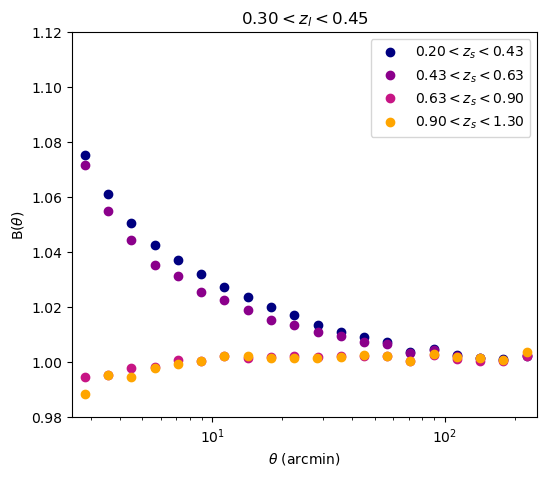

In [47]:
plt.figure(figsize=[6,5])
plt.plot(theta_b[:,3], Boost[:,3], linewidth=0, marker='o', color='navy')
plt.plot(theta_b[:,2], Boost[:,2], linewidth=0, marker='o', color='darkmagenta')
plt.plot(theta_b[:,1], Boost[:,1], linewidth=0, marker='o', color='mediumvioletred')
plt.plot(theta_b[:,0], Boost[:,0], linewidth=0, marker='o', color='orange')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'B($\theta$)')
plt.title(r'$0.30 < z_{l} < 0.45$')
plt.legend([r'$0.20<z_{s}<0.43$', r'$0.43<z_{s}<0.63$', r'$0.63<z_{s}<0.90$', r'$0.90<z_{s}<1.30$'])
plt.xscale('log')
plt.ylim([0.98,1.12])
plt.xlim([2.5,250])
plt.savefig('Boosts_zl=0.3-0.45.png')